# U.S. Chronic Disease Indicators — 快速分析
此笔记本演示对 `wen/U.S._Chronic_Disease_Indicators_20251102.csv` 的快速探索性分析。将读取 CSV、检查列与数据类型、查看缺失率、列出热门 Topic/Indicator、并绘制几张简单图表。\n\nCDC 数据预览页面：https://data.cdc.gov/Chronic-Disease-Indicators/U-S-Chronic-Disease-Indicators/hksd-2xuw/data_preview\n\n下一格会是可运行的 Python 分析代码。

CSV 路径： data/U.S._Chronic_Disease_Indicators_20251102.csv

数据形状： (309215, 34)

前几行样本：


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,TopicID,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2020,2020,US,United States,BRFSS,Health Status,Recent activity limitation among adults,NaN,Number,Age-adjusted Mean,...,HEA,HEA04,NaN,AGEADJMEAN,SEX,SEXF,NaN,NaN,NaN,NaN
1,2015,2019,AR,Arkansas,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,SEX,SEXM,NaN,NaN,NaN,NaN
2,2015,2019,CA,California,US Cancer DVT,Cancer,"Cervical cancer mortality among all females, u...",NaN,Number,Number,...,CAN,CAN03,NaN,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
3,2015,2019,CO,Colorado,US Cancer DVT,Cancer,"Invasive cancer (all sites combined), incidence",NaN,Number,Number,...,CAN,CAN07,NaN,NMBR,RACE,HIS,NaN,NaN,NaN,NaN
4,2015,2019,GA,Georgia,US Cancer DVT,Cancer,"Prostate cancer mortality among all males, und...",NaN,Number,Number,...,CAN,CAN05,NaN,NMBR,RACE,WHT,NaN,NaN,NaN,NaN



列名：
['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'DataSource', 'Topic', 'Question', 'Response', 'DataValueUnit', 'DataValueType', 'DataValue', 'DataValueAlt', 'DataValueFootnoteSymbol', 'DataValueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit', 'StratificationCategory1', 'Stratification1', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'Stratification3', 'Geolocation', 'LocationID', 'TopicID', 'QuestionID', 'ResponseID', 'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1', 'StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3']

基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309215 entries, 0 to 309214
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   YearStart                  309215 non-null  int64  
 1   YearEnd                    309215 non-null  int64  
 2   LocationA

/var/folders/fh/92l72t557vj9msc921102b4h0000gn/T/ipykernel_60150/884243172.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{int(x):,}" for x in ax.get_xticks().astype(int)], fontsize=9)


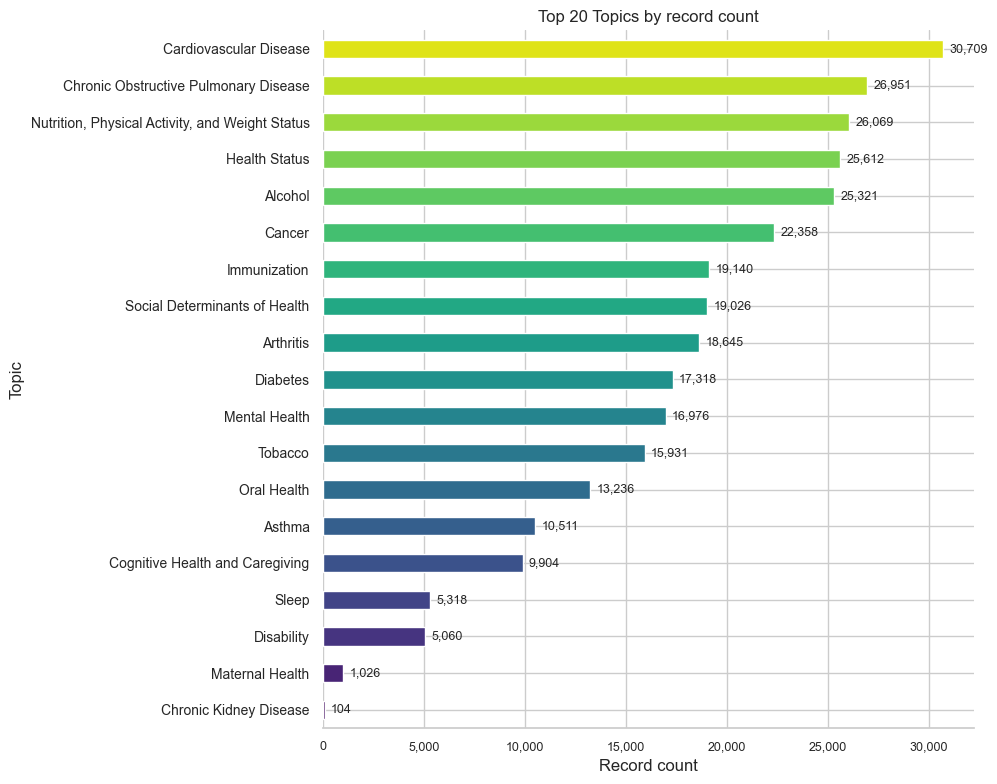

In [2]:
# 快速分析脚本：读取并检查 CSV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
sns.set(style='whitegrid')

csv_path = 'data/U.S._Chronic_Disease_Indicators_20251102.csv'
print('CSV 路径：', csv_path)

# 读取数据（low_memory=False 避免 dtype 警告）
try:
    df = pd.read_csv(csv_path, low_memory=False)
except FileNotFoundError:
    raise FileNotFoundError(f"找不到文件：{csv_path}。请确认路径相对于工作区根目录正确。")

print('\n数据形状：', df.shape)
print('\n前几行样本：')
display(df.head())

print('\n列名：')
print(list(df.columns))

print('\n基本信息：')
# 使用 info()
print(df.info())

# 缺失率概览
missing = df.isnull().mean().sort_values()
print('\n各列缺失率（前10）：')
print(missing.head(10))
print('\n各列缺失率（后10）：')
print(missing.tail(10))

# 常见文本列的值计数（如果存在）
candidate_text_cols = ['Topic', 'Indicator', 'Question', 'LocationDesc', 'YearStart', 'YearEnd']
for col in candidate_text_cols:
    if col in df.columns:
        print(f"\n-- '{col}' 的前10个值计数：")
        print(df[col].value_counts().head(10))

# 尝试识别数值列（自动）并打印前几个描述统计
num_cols = df.select_dtypes(include=['number']).columns.tolist()
# 也尝试把常见的数据值列转为数值
possible_value_cols = ['Data_Value', 'Data_Value_Alt', 'Data_value', 'Data_Value_Footnote_Symbol', 'Value']
for cand in possible_value_cols:
    if cand in df.columns and cand not in num_cols:
        df[cand + '_num'] = pd.to_numeric(df[cand], errors='coerce')
        num_cols.append(cand + '_num')

print('\n检测到的数值列示例：', num_cols[:20])
if num_cols:
    for c in num_cols[:3]:
        print(f"\n描述统计 — {c}:")
        print(df[c].describe())

# 简单可视化：Top Topics（若存在）—— 改进版横向条形图，增加配色与数值标注
if 'Topic' in df.columns:
    top_topics = df['Topic'].value_counts().nlargest(20)
    plt.figure(figsize=(10,8))
    sns.set_palette('viridis')
    # 横向条形、按计数升序显示（上方为最大）
    ax = top_topics.sort_values().plot(kind='barh', color=sns.color_palette('viridis', n_colors=len(top_topics)))
    plt.title('Top 20 Topics by record count')
    plt.xlabel('Record count')
    plt.ylabel('Topic')
    # 调整字体大小以避免覆盖
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_xticklabels([f"{int(x):,}" for x in ax.get_xticks().astype(int)], fontsize=9)
    plt.tight_layout()
    # 添加数值标注到条形末端
    max_count = top_topics.max()
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(width + max_count * 0.01, y, f"{int(width):,}", va='center', fontsize=9)
    sns.despine(left=True, bottom=False)
    plt.show()

Binge drinking frequency among adults who binge drink
在有暴饮行为的成年人中，暴饮频率

Binge drinking intensity among adults who binge drink
在有暴饮行为的成年人中，暴饮强度

Cerebrovascular disease (stroke) mortality among all people, underlying cause
脑血管疾病（中风）死亡率（所有人群，作为原发原因）

Diabetes mortality among all people, underlying or contributing cause
糖尿病死亡率（所有人群，作为原发或助因）

Chronic liver disease mortality among all people, underlying cause
慢性肝病死亡率（所有人群，作为原发原因）

Diabetic ketoacidosis mortality among all people, underlying or contributing cause
糖尿病酮症酸中毒致死率（所有人群，作为原发或助因）

Diseases of the heart mortality among all people, underlying cause
心脏疾病死亡率（所有人群，作为原发原因）

Coronary heart disease mortality among all people, underlying cause
冠心病死亡率（所有人群，作为原发原因）

Asthma mortality among all people, underlying cause
哮喘死亡率（所有人群，作为原发原因）

Chronic obstructive pulmonary disease mortality among adults aged 45 years and older, underlying or contributing cause
≥45岁成人慢性阻塞性肺疾病（COPD）死亡率（作为原发或助因）

Chronic obstructive pulmonary disease mortality among adults aged 45 years and older, underlying cause
≥45岁成人慢性阻塞性肺疾病（COPD）死亡率（作为原发原因）

Average recent physically unhealthy days among adults
成人近期平均身体不健康天数

Chronic obstructive pulmonary disease among adults
成人慢性阻塞性肺疾病（COPD）

Current cigarette smoking among adults
成人当前吸烟情况（现吸烟者比例）

Recent activity limitation among adults
成人近期活动受限情况

Depression among adults
成人抑郁情况（抑郁患病率）

Routine checkup within the past year among adults
成人过去一年内例行体检情况

Diabetes among adults
成人糖尿病（患病率）

Adults with any disability
有任何残疾的成人

Influenza vaccination among adults
成人流感疫苗接种情况

In [7]:
# 稳健版：按 Question 分类并生成汇总（可直接替换原单元）
import pandas as pd
from IPython.display import display

# 假定 df 已存在；若不存在则尝试从 csv_path 读取
if 'df' not in globals():
    csv_path = globals().get('csv_path', 'data/U.S._Chronic_Disease_Indicators_20251102.csv')
    df = pd.read_csv(csv_path, low_memory=False)
    print(f"从 {csv_path} 读取 df（行数：{len(df)}）")

# 确保 Question 存在
if 'Question' not in df.columns:
    raise KeyError("数据中没有 'Question' 列，请先确认 CSV 内容。")

df = df.copy()
df['Question_clean'] = df['Question'].astype(str).str.strip()

# 辅助：根据候选名找到实际列名
def find_col(*cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

col_map = {
    'indicator': find_col('Indicator', 'IndicatorName', 'IndicatorID'),
    'data_value': find_col('Data_Value', 'DataValue', 'DataValue', 'DataValueNum', 'DataValueNum'),
    'data_value_type': find_col('Data_Value_Type', 'DataValueType'),
    'data_value_unit': find_col('Data_Value_Unit', 'DataValueUnit'),
    'response': find_col('Response'),
    'topic': find_col('Topic')
}
print("检测到的列映射：", col_map)

# 按 Question 分组，逐项计算（分步计算避免 groupby.agg 的 KeyError）
g = df.groupby('Question_clean', dropna=False)
summary = pd.DataFrame({
    'n_records': g.size()
})

# 可选字段：Indicator 的不同值数量 & top indicators
if col_map['indicator']:
    summary['n_indicators'] = g[col_map['indicator']].nunique()
    summary['top_indicators'] = g[col_map['indicator']].apply(
        lambda s: ', '.join(s.dropna().astype(str).value_counts().head(5).index.astype(str))
    )
else:
    # 没有 indicator 列：尝试用 Topic+QuestionID 或 QuestionID 代替（如果有）
    fallback = find_col('QuestionID', 'TopicID')
    if fallback:
        summary['n_indicators'] = g[fallback].nunique()
        summary['top_indicators'] = g[fallback].apply(
            lambda s: ', '.join(s.dropna().astype(str).value_counts().head(5).index.astype(str))
        )
    else:
        summary['n_indicators'] = 0
        summary['top_indicators'] = ''

# Response 示例（注意你原始输出显示 Response 全是 NaN）
if col_map['response']:
    summary['sample_responses'] = g[col_map['response']].apply(
        lambda s: ', '.join(s.dropna().astype(str).value_counts().head(5).index.astype(str))
    )
else:
    summary['sample_responses'] = ''

# Data value type / unit（如果存在）
if col_map['data_value_type']:
    summary['data_value_types'] = g[col_map['data_value_type']].apply(
        lambda s: ', '.join(pd.Series(s.dropna().astype(str).unique())[:5].tolist())
    )
else:
    summary['data_value_types'] = ''

if col_map['data_value_unit']:
    summary['value_units'] = g[col_map['data_value_unit']].apply(
        lambda s: ', '.join(pd.Series(s.dropna().astype(str).unique())[:5].tolist())
    )
else:
    summary['value_units'] = ''

# numeric count（如果存在 DataValue 列）
if col_map['data_value']:
    summary['numeric_count'] = g[col_map['data_value']].apply(
        lambda s: int(pd.to_numeric(s, errors='coerce').notna().sum())
    )
else:
    summary['numeric_count'] = 0

# 重置索引并排序展示
summary = summary.reset_index().rename(columns={'Question_clean':'Question'})
summary_sorted = summary.sort_values('n_records', ascending=False).reset_index(drop=True)

print(f"总共不同 Question: {summary_sorted.shape[0]}")
print("\n按记录数排序的前 20 个 Question：")
display(summary_sorted.head(20))

# 展示前 3 个 Question 的原始行示例（如有）
top_questions = summary_sorted['Question'].head(3).tolist()
for i, q in enumerate(top_questions, start=1):
    print(f"\n=== 示例 {i}: Question = {q} (显示前 5 行) ===")
    display(df[df['Question_clean'] == q].head(5))

# 保存变量供后续使用
question_summary = summary_sorted
print("\n完成：结果保存在变量 `question_summary` 中。")

检测到的列映射： {'indicator': None, 'data_value': 'DataValue', 'data_value_type': 'DataValueType', 'data_value_unit': 'DataValueUnit', 'response': 'Response', 'topic': 'Topic'}
总共不同 Question: 109

按记录数排序的前 20 个 Question：


,Question,n_records,n_indicators,top_indicators,sample_responses,data_value_types,value_units,numeric_count
0,Binge drinking frequency among adults who bing...,5720,1,ALC04,,"Crude Median, Crude 75th percentile",Number,3273
1,Binge drinking intensity among adults who bing...,5680,1,ALC05,,"Crude Median, Crude 75th percentile",Number,3462
2,Cerebrovascular disease (stroke) mortality amo...,5616,1,CVD07,,"Number, Crude Rate, Age-adjusted Rate","Number, cases per 100,000",3361
3,"Diabetes mortality among all people, underlyin...",5616,1,DIA03,,"Number, Age-adjusted Rate, Crude Rate","Number, cases per 100,000",3585
4,Chronic liver disease mortality among all peop...,5616,1,ALC09,,"Number, Crude Rate, Age-adjusted Rate","Number, cases per 100,000",3484
5,Diabetic ketoacidosis mortality among all peop...,5616,1,DIA04,,"Number, Crude Rate, Age-adjusted Rate","Number, cases per 100,000",2466
6,Diseases of the heart mortality among all peop...,5616,1,CVD09,,"Number, Age-adjusted Rate, Crude Rate","Number, cases per 100,000",3554
7,Coronary heart disease mortality among all peo...,5616,1,CVD08,,"Number, Age-adjusted Rate, Crude Rate","Number, cases per 100,000",3401
8,"Asthma mortality among all people, underlying ...",5616,1,AST01,,"Number, Age-adjusted Rate, Crude Rate","Number, cases per 100,000",1869
9,Chronic obstructive pulmonary disease mortalit...,5304,1,COPD06,,"Number, Crude Rate, Age-adjusted Rate","Number, cases per 100,000",3006



=== 示例 1: Question = Binge drinking frequency among adults who binge drink (显示前 5 行) ===


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Question_clean
84,2020,2020,WV,West Virginia,BRFSS,Alcohol,Binge drinking frequency among adults who bing...,NaN,Number,Crude Median,...,ALC04,NaN,CRDMEDN,RACE,HIS,NaN,NaN,NaN,NaN,Binge drinking frequency among adults who bing...
172,2019,2019,MD,Maryland,BRFSS,Alcohol,Binge drinking frequency among adults who bing...,NaN,Number,Crude 75th percentile,...,ALC04,NaN,CRD75TH,AGE,AGE65P,NaN,NaN,NaN,NaN,Binge drinking frequency among adults who bing...
218,2019,2019,NV,Nevada,BRFSS,Alcohol,Binge drinking frequency among adults who bing...,NaN,Number,Crude Median,...,ALC04,NaN,CRDMEDN,AGE,AGE1844,NaN,NaN,NaN,NaN,Binge drinking frequency among adults who bing...
294,2019,2019,PR,Puerto Rico,BRFSS,Alcohol,Binge drinking frequency among adults who bing...,NaN,Number,Crude 75th percentile,...,ALC04,NaN,CRD75TH,AGE,AGE65P,NaN,NaN,NaN,NaN,Binge drinking frequency among adults who bing...
320,2019,2019,TX,Texas,BRFSS,Alcohol,Binge drinking frequency among adults who bing...,NaN,Number,Crude 75th percentile,...,ALC04,NaN,CRD75TH,SEX,SEXF,NaN,NaN,NaN,NaN,Binge drinking frequency among adults who bing...



=== 示例 2: Question = Binge drinking intensity among adults who binge drink (显示前 5 行) ===


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Question_clean
135,2019,2019,IL,Illinois,BRFSS,Alcohol,Binge drinking intensity among adults who bing...,NaN,Number,Crude Median,...,ALC05,NaN,CRDMEDN,AGE,AGE65P,NaN,NaN,NaN,NaN,Binge drinking intensity among adults who bing...
173,2019,2019,MD,Maryland,BRFSS,Alcohol,Binge drinking intensity among adults who bing...,NaN,Number,Crude Median,...,ALC05,NaN,CRDMEDN,AGE,AGE1844,NaN,NaN,NaN,NaN,Binge drinking intensity among adults who bing...
336,2019,2019,UT,Utah,BRFSS,Alcohol,Binge drinking intensity among adults who bing...,NaN,Number,Crude 75th percentile,...,ALC05,NaN,CRD75TH,AGE,AGE4564,NaN,NaN,NaN,NaN,Binge drinking intensity among adults who bing...
466,2020,2020,MD,Maryland,BRFSS,Alcohol,Binge drinking intensity among adults who bing...,NaN,Number,Crude 75th percentile,...,ALC05,NaN,CRD75TH,AGE,AGE1844,NaN,NaN,NaN,NaN,Binge drinking intensity among adults who bing...
746,2021,2021,NE,Nebraska,BRFSS,Alcohol,Binge drinking intensity among adults who bing...,NaN,Number,Crude Median,...,ALC05,NaN,CRDMEDN,OVERALL,OVR,NaN,NaN,NaN,NaN,Binge drinking intensity among adults who bing...



=== 示例 3: Question = Cerebrovascular disease (stroke) mortality among all people, underlying cause (显示前 5 行) ===


,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,...,QuestionID,ResponseID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,Question_clean
93,2019,2019,CT,Connecticut,NVSS,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,NaN,Number,Number,...,CVD07,NaN,NMBR,AGE,AGE65P,NaN,NaN,NaN,NaN,Cerebrovascular disease (stroke) mortality amo...
180,2019,2019,MI,Michigan,NVSS,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,NaN,"cases per 100,000",Crude Rate,...,CVD07,NaN,CRDRATE,SEX,SEXM,NaN,NaN,NaN,NaN,Cerebrovascular disease (stroke) mortality amo...
205,2019,2019,MT,Montana,NVSS,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,NaN,Number,Number,...,CVD07,NaN,NMBR,AGE,AGE0_44,NaN,NaN,NaN,NaN,Cerebrovascular disease (stroke) mortality amo...
237,2019,2019,NJ,New Jersey,NVSS,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,NaN,Number,Number,...,CVD07,NaN,NMBR,AGE,AGE4564,NaN,NaN,NaN,NaN,Cerebrovascular disease (stroke) mortality amo...
255,2019,2019,NY,New York,NVSS,Cardiovascular Disease,Cerebrovascular disease (stroke) mortality amo...,NaN,Number,Number,...,CVD07,NaN,NMBR,RACE,BLK,NaN,NaN,NaN,NaN,Cerebrovascular disease (stroke) mortality amo...



完成：结果保存在变量 `question_summary` 中。


In [3]:
# ========================================
# 第一步：详细分析数据结构并生成 SQL DDL
# ========================================
import pandas as pd
import json

print("="*80)
print("【数据结构分析与 SQL 代码生成】")
print("="*80)

# 确保 df 存在
if 'df' not in globals():
    csv_path = 'data/U.S._Chronic_Disease_Indicators_20251102.csv'
    df = pd.read_csv(csv_path, low_memory=False)
    print(f"从 {csv_path} 读取数据")

print(f"\n📊 数据集规模：{df.shape[0]:,} 行 × {df.shape[1]} 列")
print("\n📋 列名和数据类型：")
print("-" * 80)
for col_name, dtype in df.dtypes.items():
    non_null_count = df[col_name].notna().sum()
    null_count = df[col_name].isna().sum()
    null_pct = (null_count / len(df)) * 100
    unique_count = df[col_name].nunique()
    print(f"{col_name:30s} | {str(dtype):15s} | 非空: {non_null_count:8,} | 缺失: {null_pct:5.1f}% | 唯一值: {unique_count:6,}")

print("\n" + "="*80)
print("【样本数据查看】")
print("="*80)
print(df.head(3).to_string())

print("\n" + "="*80)
print("【关键列的值域统计】")
print("="*80)

# 分析关键维度列
key_cols = {
    'Topic': 'Topic - 健康主题',
    'Question': 'Question - 具体问题',
    'LocationDesc': 'LocationDesc - 地理位置',
    'YearStart': 'YearStart - 开始年份',
    'YearEnd': 'YearEnd - 结束年份',
    'Data_Value_Type': 'Data_Value_Type - 数据值类型'
}

for col, desc in key_cols.items():
    if col in df.columns:
        print(f"\n▸ {desc}")
        print(f"  唯一值数: {df[col].nunique()}")
        if df[col].dtype == 'object':
            print(f"  样本值: {df[col].dropna().head(3).tolist()}")
        else:
            print(f"  范围: [{df[col].min()}, {df[col].max()}]")

# 分析数值列
print("\n▸ 数值列（Data_Value）统计")
if 'Data_Value' in df.columns:
    data_val = pd.to_numeric(df['Data_Value'], errors='coerce')
    print(f"  有效值: {data_val.notna().sum():,}")
    print(f"  范围: [{data_val.min():.2f}, {data_val.max():.2f}]")
    print(f"  平均值: {data_val.mean():.2f}")


【数据结构分析与 SQL 代码生成】

📊 数据集规模：309,215 行 × 34 列

📋 列名和数据类型：
--------------------------------------------------------------------------------
YearStart                      | int64           | 非空:  309,215 | 缺失:   0.0% | 唯一值:      7
YearEnd                        | int64           | 非空:  309,215 | 缺失:   0.0% | 唯一值:      4
LocationAbbr                   | object          | 非空:  309,215 | 缺失:   0.0% | 唯一值:     55
LocationDesc                   | object          | 非空:  309,215 | 缺失:   0.0% | 唯一值:     55
DataSource                     | object          | 非空:  309,215 | 缺失:   0.0% | 唯一值:     14
Topic                          | object          | 非空:  309,215 | 缺失:   0.0% | 唯一值:     19
Question                       | object          | 非空:  309,215 | 缺失:   0.0% | 唯一值:    109
Response                       | float64         | 非空:        0 | 缺失: 100.0% | 唯一值:      0
DataValueUnit                  | object          | 非空:  309,215 | 缺失:   0.0% | 唯一值:      8
DataValueType                  | object    

In [4]:
# ========================================
# 第二步：生成 SQL DDL 代码并保存为 SQL 文件
# ========================================
import pandas as pd

print("="*80)
print("【生成 Data Lake 层 SQL DDL 代码】")
print("="*80)

# 确保 df 存在
if 'df' not in globals():
    csv_path = 'data/U.S._Chronic_Disease_Indicators_20251102.csv'
    df = pd.read_csv(csv_path, low_memory=False)

# 获取所有列名和类型
columns_info = []
for col_name in df.columns:
    dtype = df[col_name].dtype
    
    # 根据 pandas dtype 映射到 SQL 类型
    if dtype == 'object':
        max_len = df[col_name].astype(str).str.len().max()
        max_len = int(max_len) if pd.notna(max_len) else 255
        max_len = max(max_len, 255)  # 最少 255
        sql_type = f"VARCHAR({max_len})"
    elif dtype == 'int64' or dtype == 'int32':
        sql_type = "INT"
    elif dtype == 'float64' or dtype == 'float32':
        sql_type = "DECIMAL(18, 4)"
    elif dtype == 'bool':
        sql_type = "BOOLEAN"
    else:
        sql_type = "TEXT"
    
    columns_info.append((col_name, sql_type))

# 生成 SQL DDL 脚本
sql_script = """-- ============================================================================
-- Data Lake Schema: 美国慢性病指标数据 (U.S. Chronic Disease Indicators)
-- 目的：存储来自 CDC 的原始慢性病指标数据
-- 创建日期：2025-11-04
-- ============================================================================

-- Drop existing table if needed (可选)
-- DROP TABLE IF EXISTS stg_us_chronic_disease_raw;

-- 创建 Data Lake 表：原始慢性病指标数据
CREATE TABLE stg_us_chronic_disease_raw (
"""

# 添加所有列定义
for i, (col_name, sql_type) in enumerate(columns_info):
    if i == len(columns_info) - 1:
        sql_script += f"    {col_name:40s} {sql_type}\n"
    else:
        sql_script += f"    {col_name:40s} {sql_type},\n"

sql_script += """);

-- 创建索引以提高查询性能
CREATE INDEX idx_stg_topic ON stg_us_chronic_disease_raw(Topic);
CREATE INDEX idx_stg_question ON stg_us_chronic_disease_raw(Question);
CREATE INDEX idx_stg_location ON stg_us_chronic_disease_raw(LocationDesc);
CREATE INDEX idx_stg_year ON stg_us_chronic_disease_raw(YearStart, YearEnd);
CREATE INDEX idx_stg_data_value ON stg_us_chronic_disease_raw(Data_Value);

-- ============================================================================
-- 加载数据到 Data Lake 表的示例命令（根据数据库类型调整）
-- ============================================================================

-- PostgreSQL 示例：
-- COPY stg_us_chronic_disease_raw FROM '/path/to/U.S._Chronic_Disease_Indicators_20251102.csv' 
--     WITH (FORMAT csv, HEADER true, DELIMITER ',', NULL 'NULL');

-- MySQL 示例：
-- LOAD DATA LOCAL INFILE '/path/to/U.S._Chronic_Disease_Indicators_20251102.csv'
--     INTO TABLE stg_us_chronic_disease_raw
--     FIELDS TERMINATED BY ','
--     ENCLOSED BY '"'
--     LINES TERMINATED BY '\\n'
--     IGNORE 1 ROWS;

-- SQLite 示例：
-- .mode csv
-- .import U.S._Chronic_Disease_Indicators_20251102.csv stg_us_chronic_disease_raw
"""

# 显示生成的 SQL 代码
print("\n📄 生成的 SQL DDL 代码：\n")
print(sql_script)

# 保存为 SQL 文件
output_sql_file = 'data_lake_us_chronic_disease_raw.sql'
with open(output_sql_file, 'w', encoding='utf-8') as f:
    f.write(sql_script)

print("\n" + "="*80)
print(f"✅ SQL 文件已保存：{output_sql_file}")
print("="*80)

# 显示表结构摘要
print("\n📊 表结构摘要：")
print(f"   表名: stg_us_chronic_disease_raw")
print(f"   列数: {len(columns_info)}")
print(f"   行数: {len(df):,}")
print(f"\n   列定义（前 10 个）：")
for col_name, sql_type in columns_info[:10]:
    print(f"      - {col_name:40s} {sql_type}")
if len(columns_info) > 10:
    print(f"      ... 以及 {len(columns_info) - 10} 个其他列")


【生成 Data Lake 层 SQL DDL 代码】

📄 生成的 SQL DDL 代码：

-- ============================================================================
-- Data Lake Schema: 美国慢性病指标数据 (U.S. Chronic Disease Indicators)
-- 目的：存储来自 CDC 的原始慢性病指标数据
-- 创建日期：2025-11-04
-- ============================================================================

-- Drop existing table if needed (可选)
-- DROP TABLE IF EXISTS stg_us_chronic_disease_raw;

-- 创建 Data Lake 表：原始慢性病指标数据
CREATE TABLE stg_us_chronic_disease_raw (
    YearStart                                INT,
    YearEnd                                  INT,
    LocationAbbr                             VARCHAR(255),
    LocationDesc                             VARCHAR(255),
    DataSource                               VARCHAR(255),
    Topic                                    VARCHAR(255),
    Question                                 VARCHAR(255),
    Response                                 DECIMAL(18, 4),
    DataValueUnit                            VARCHAR(255),
    D